https://app.dominodatalab.com/u/LeJit/FacebookNetwork/view/SocialNetwork.ipynb  
https://blog.dominodatalab.com/social-network-analysis-with-networkx

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

# Exploratory Data Analysis

In [5]:
G_fb = nx.read_edgelist("data/facebook_combined.txt", create_using=nx.Graph(), nodetype=int)

In [6]:
# Quick snapshot of the network
print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
# Create network layout for visualizations
spring_pos = nx.spring_layout(G_fb)

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


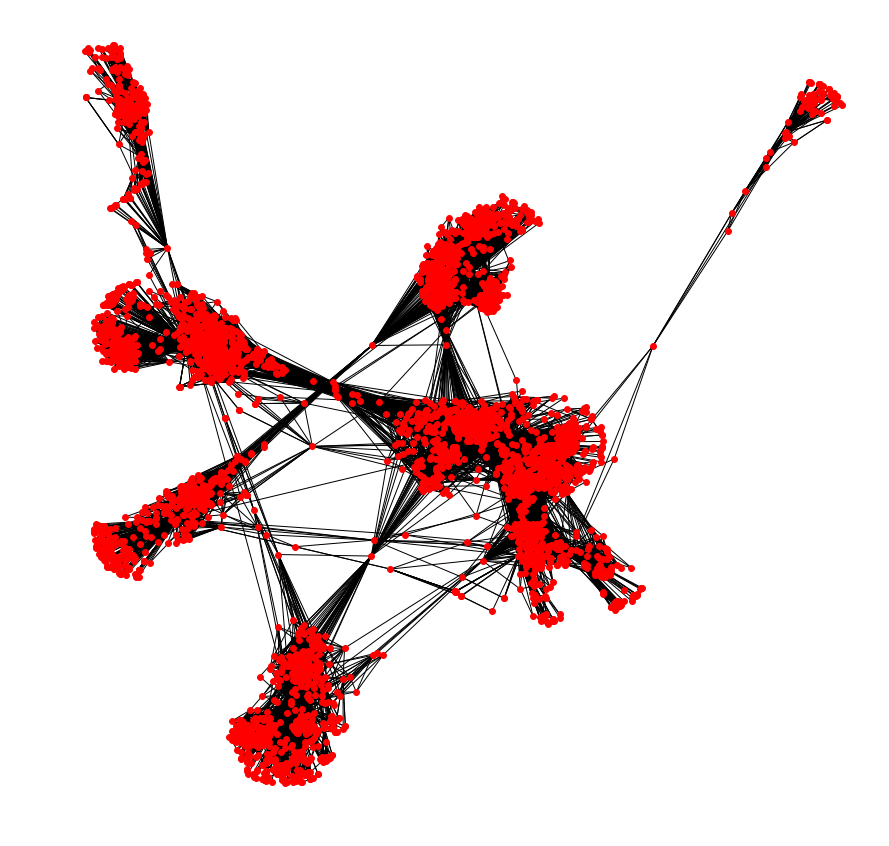

In [8]:
plt.figure(figsize=(15, 15))
plt.axis("off")
nx.draw_networkx(G_fb, pos=spring_pos, with_labels=False, node_size=35)

# Parallel betweenness centrality

In [33]:
from multiprocessing import Pool
import itertools

In [34]:
def partitions(nodes, n):
    """
    Partitions the nodes into n subsets
    """
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter, n))
        if not partition:
            return
        yield partition

In [35]:
def btwn_pool(G_tuple):
    """
    Pool for multiprocess only accepts functions with one argument.
    This function uses a tuple as its only argument. We use a named tuple for
    python 3 compatibility, and then unpack it when we send it to
    betweenness_centrality_source.
    """
    return nx.betweenness_centrality_source(*G_tuple)

In [36]:
def between_parallel(G, processes=None):
    p = Pool(processes=processes)
    part_generator = 4 * len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G) / part_generator)))
    num_partitions = len(node_partitions)
    
    bet_map = p.map(btwn_pool,
                        zip([G] * num_partitions,  # G
                        [True] * num_partitions,   # normalized
                        [None] * num_partitions,   # weight
                        node_partitions))          # sources
    
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

### Zip: an example

In [37]:
# step 1. zip for pool (a function that uses a tuple as its only argument)
# step 2. unzip for betweenness_centrality_source

# 1. zip
argument = ['G', 'normalized', 'weighted_edges', 'sources']
value = [G_fb, True, False, None]

z = zip(argument, value)
print(z)  # zip object
zTuple = tuple(z)
print(zTuple)

# 2. unzip
a, v = zip(*zTuple)
print('a =', a)
print('v =', v)

(('G', <networkx.classes.graph.Graph object at 0xa1ced1470>), ('normalized', True), ('weighted_edges', False), ('sources', None))
a = ('G', 'normalized', 'weighted_edges', 'sources')
v = (<networkx.classes.graph.Graph object at 0xa1ced1470>, True, False, None)


### Sorted: an example

In [38]:
bt_items = [(0, 0.23),  # node, centrality
            (1, 0.15),
            (2, 0.25)]

sorted(bt_items, key=lambda v: -v[1])  # sort by value

[(2, 0.25), (0, 0.23), (1, 0.15)]

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


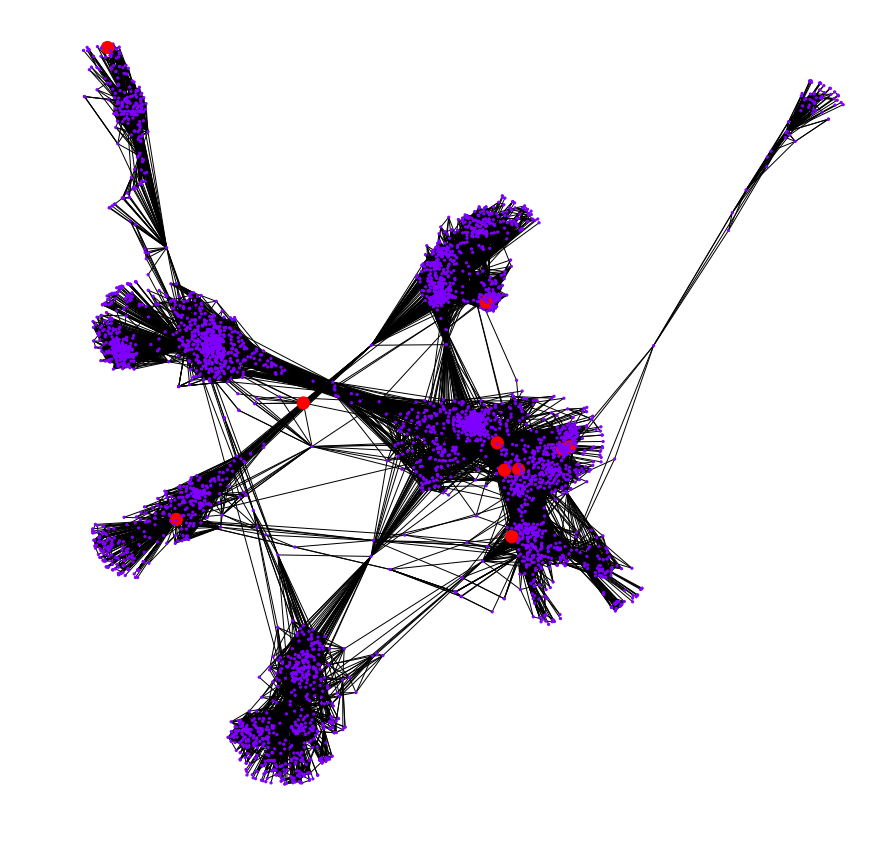

In [39]:
bt = between_parallel(G_fb)
top = 10

max_nodes = sorted(bt.items(), key = lambda v: -v[1])[:top]
bt_values = [5] * len(G_fb.nodes())
bt_colors = [0] * len(G_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2

plt.figure(figsize=(15, 15))
plt.axis("off")
nx.draw_networkx(G_fb, pos=spring_pos, cmap=plt.get_cmap("rainbow"), node_color=bt_colors, node_size=bt_values, with_labels=False)

# Community Detection

In [40]:
import community

In [41]:
parts = community.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


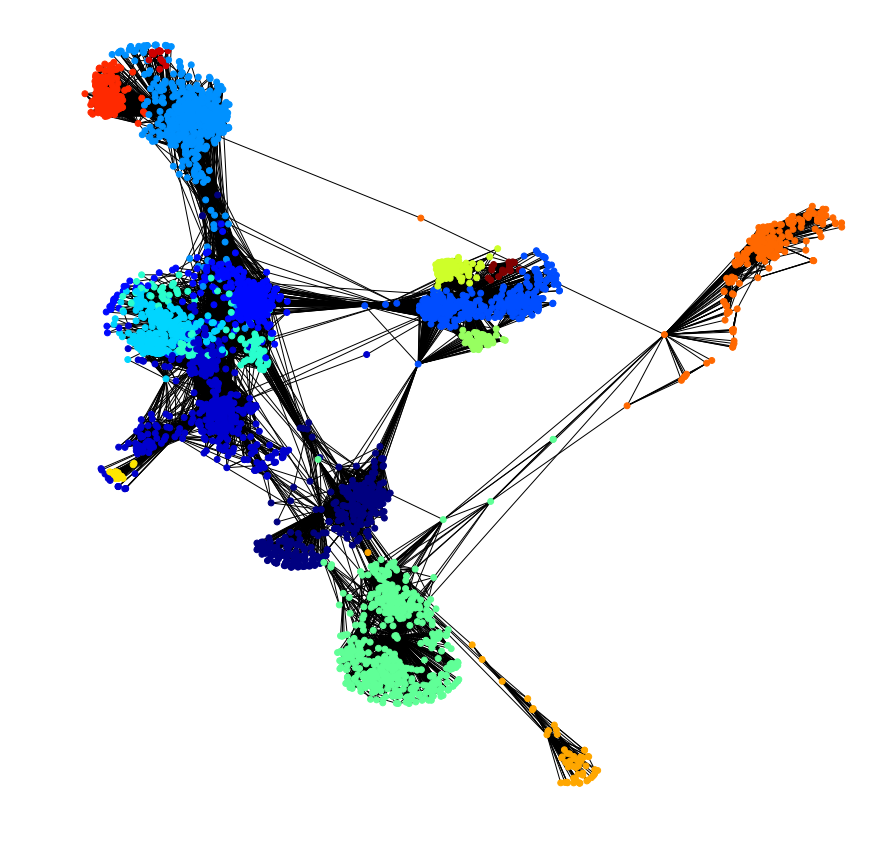

In [50]:
plt.figure(figsize=(15, 15))
plt.axis("off")
nx.draw_networkx(G_fb, pos=spring_pos, cmap=plt.get_cmap("jet"), node_color=values, node_size=35, with_labels=False)